### Action selection using upper confidence bounds

Upper confidence bounds (UCB) is a simple yet effective solution to the
exploration-exploitation trade-off. The idea is that at each time step, we select the
action that has the highest potential for reward.
The potential of the action is calculated as the sum of the action value estimate and a measure of the uncertainty of this estimate. This sum is what we call the UCB. So, an action is selected either because our estimate for the action value is high, or the action has not been explored enough (that is, as many times as the other ones) and there is high uncertainty about its value, or both.

We select the action to take at time using the following formula:
![](img/ucb.png)

* Formula looks at the values of Q and N (which may have been updated a while ago at the decision-making, t). No update here.
* Square root is to measure uncertainty for the estimate of the action value of the action.
* **The more we select the action, the less uncertainty we have about its value**, and so is the N(a) term in the denominator.
* As time passes the uncertainty grows due to the ln t term (makes sense if env is not stationary). So more exploration is encouraged.
* Hyperparameter c controls the emphasis on uncertainty.

### Application to the online advertising scenario

In [2]:
import numpy as np

In [37]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
# model of ad behavior
class BernoulliBandit(object):
    def __init__(self, p):
        self.p = p
    # rewards come from Bernoulli dist. for the ad
    def display_ad(self):
        reward = np.random.binomial(n=1, p=self.p)
        return reward

In [4]:
adA = BernoulliBandit(0.004)
adB = BernoulliBandit(0.016)
adC = BernoulliBandit(0.025)
adD = BernoulliBandit(0.035)
adE = BernoulliBandit(0.028)
ads = [adA, adB, adC, adD, adE]

In [34]:
c = 10
n_prod = 100000
n_ads = len(ads)
ad_indices = np.array(range(n_ads))
Q = np.zeros(n_ads)
N = np.zeros(n_ads)
total_reward = 0
avg_rewards = []

In [29]:
import pandas as pd
df_reward_comparison = pd.DataFrame()

In [35]:
for t in range(1, n_prod + 1):
    if any(N==0):
        # If an action has not been selected yet, it has the highest UCB
        ad_chosen = np.random.choice(ad_indices[N==0])
    else:
        uncertainty = np.sqrt(np.log(t) / N)
        ad_chosen = np.argmax(Q + c * uncertainty)  # choose highest UCB
    R = ads[ad_chosen].display_ad()
    N[ad_chosen] += 1
    # update action value
    Q[ad_chosen] += (1 / N[ad_chosen]) * (R - Q[ad_chosen])
    total_reward += R
    avg_reward_so_far = total_reward / t
    avg_rewards.append(avg_reward_so_far)


df_reward_comparison['UCB, c={}'.format(c)] = avg_rewards

   UCB, c=0.1  UCB, c=1  UCB, c=10
0         0.0       0.0        0.0
1         0.0       0.0        0.0
2         0.0       0.0        0.0
3         0.0       0.0        0.0
4         0.0       0.0        0.0


<AxesSubplot:>

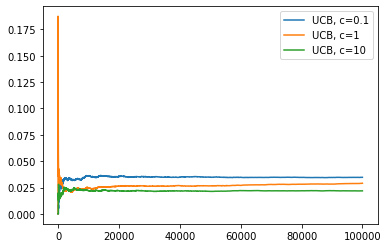

In [40]:
# Need to run UCB with the specified values or modify the ucb_list to what you have.
ucb_list = ['UCB, c=0.1', 'UCB, c=1', 'UCB, c=10']
print(df_reward_comparison.head())
best_reward = df_reward_comparison.loc[t-1,ucb_list].max()
df_reward_comparison[ucb_list].plot()

### Tip
Try hyperparameters in a logarithmic scale, such as [0.01, 0.1, 1, 10], rather
than a linear scale, such as [0.08, 0.1, 0.12, 0.14]. The former allows exploring
different orders of magnitude, where we could see significant jumps in
performance. A search on a linear scale could be used after identifying the right
order of magnitude.